In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(20056, 28)
(20056, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, 24] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.14419609e-02,
       -1.36477514e-02, -1.27038601e-02, -2.44656499e-03,  5.16659591e-03,
        1.42379109e-02, -7.15826028e-02, -3.98971194e-01,  2.48611214e-04,
       -3.99555782e-01,  1.79192922e-02, -3.67993488e-04,  4.02828296e-01,
       -2.67053265e-02,  2.49471553e-04,  4.63155301e-02,  3.97264324e-01,
       -1.33312154e-04,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_RR_swinging[0, :]

array([0.01216075, 0.00131568, 0.01196473, 0.00102708])

### Linear Regression

In [13]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9502790928612299
RMSE:  0.016270586629974302
The lowest error is:  9.549314674853204e-06
The highest error is:  0.08043789229223702
The avg. error is:  0.011814636180991088


In [14]:
model_rr_relative_swinging_x.coef_

array([[-0.03228989,  0.04333071,  0.04734508,  0.22535789,  0.00342114,
         0.01462493,  0.07372918,  0.04560112, -0.44280749,  0.59339176,
        -0.47473278,  0.52993172, -0.01489859,  0.11369561]])

In [15]:
model_rr_relative_swinging_x.intercept_

array([0.0101464])

Text(0, 0.5, 'Predictions')

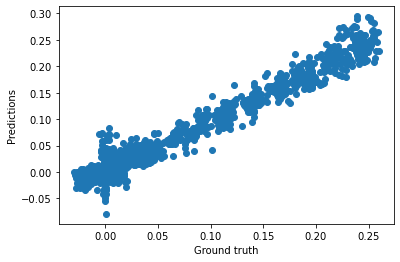

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [17]:
#%store model_rr_relative_swinging_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [21]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8631510570451117
RMSE:  0.01592515897320512
The lowest error is:  2.854261679096845e-06
The highest error is:  0.08808095867173574
The avg. error is:  0.009288853400599756


In [22]:
model_rr_relative_swinging_y.coef_

array([[ 0.00430843, -0.0094233 , -0.04601245,  0.0095601 ,  0.22908025,
        -0.02334645, -0.14012686,  0.07798112, -0.09587673, -0.00097512,
        -0.17499111,  0.12768332, -0.01252009,  0.14206591]])

In [23]:
model_rr_relative_swinging_y.intercept_

array([-0.00334501])

Text(0, 0.5, 'Predictions')

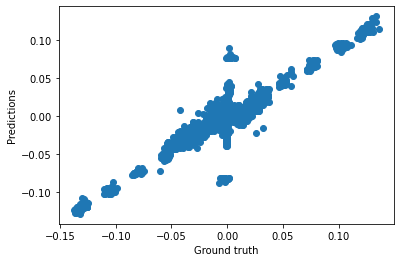

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")